# Estimate Sample Difficulty to Simulate Annotators

In [1]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

from annotlib import DifficultyBasedAnnot

The class [DifficultyBasedAnnot](../annotlib.difficulty_based.rst) implements a simulation technique aiming at quantifying the difficulty of a sample. The estimated difficulty is used in combination with an annotator labelling performance to compute the probability that the corresponding annotator labels the sample correctly.
The difficulty of a sample $\mathbf{x}$ is denoted by $\frac{1}{\beta_\mathbf{x}}$ where $\beta \in [0, \infty)$ is the inverse difficulty. The annotator $a_i$ has the labelling performance $\alpha_i \in (-\infty, \infty)$. The probability of a correct label is then given by

$$p(y^{(\text{true})}_\mathbf{x} \mid \alpha_i, \beta_\mathbf{x}) = \frac{1}{1+(C - 1) \cdot \text{exp}(-\alpha_i \beta_\mathbf{x})},$$

where $y^{(\text{true})}_\mathbf{x}$ is the true class label of sample $\mathbf{x}$ and $C$ is the number of different classes (`n_classes`). An illustration of this logistic sigmoid function is given for different parametrisations below.

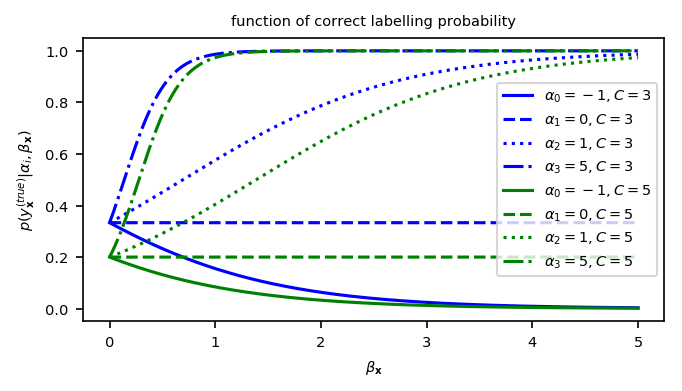

In [2]:
# plot probability function for different parametrisations
n_classes = [3, 5]
alphas = np.array([-1, 0, 1, 5])
betas = np.linspace(0, 5, 10000)
color = ['b', 'g']
lines = ['-', '--', ':', '-.']
plt.figure(figsize=(5, 2.5), dpi=150)
for c in range(len(n_classes)):
    proba = 1 / (1 + (n_classes[c] - 1) * 
            np.exp(-betas.reshape(-1, 1) @ alphas.reshape(1, -1)))
    for a in range(len(alphas)):
        plt.plot(betas, proba[:, a], label=r'$\alpha_'+ str(a) 
                 +' = '+str(alphas[a]) + 
                 ', C = '+str(n_classes[c])+'$', 
                 color=color[c], linestyle=lines[a])
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel(r'$\beta_\mathbf{x}$', fontsize=7)
plt.ylabel(r'$p(y^{(true)}_\mathbf{x} | \alpha_i, \beta_\mathbf{x})$', 
           fontsize=7)
plt.legend(fontsize=7)
plt.title('function of correct labelling probability', fontsize=7)
plt.show()

The above plot shows the function $p(y^{(\text{true})}_\mathbf{x} \mid \alpha_i, \beta_\mathbf{x})$ for different labelling performance scores $\alpha_i$, different sample difficulty scores $\frac{1}{\beta_\mathbf{x}}$, and different numbers of classes $C$. There are two horizontal lines representing annotator $a_1$ who is randomly guessing. This annotator has a labelling performance score of $\alpha_1 = 0$. As a result, the probability for providing the correct label is $\frac{1}{C}$ for all difficulty scores. If the labelling performance score $\alpha_i$ is greater than zero, we observe the probability for correct labelling increases along the $\beta_\mathbf{x}$-axis (see annotator $a_2$ and $a_3$ who have the labelling performances $\alpha_2 = 2$ and $\alpha_3 = 5$). Correspondingly, a decreasing difficulty score $\frac{1}{\beta_\mathbf{x}}$ implies that the labelling is getting easier. A difficulty score of infinity $\frac{1}{\beta_\mathbf{x}}=\infty$ is a special case, because the labelling of an instance is so difficult that an annotator can only guess (independently of the labelling performance score). Moreover, the plot shows that increasing labelling performance $\alpha_i$ leads to an increasing probability for correct class labels, since $\alpha_3 > \alpha_2$ indicates that annotator $a_3$ is better than annotator $a_2$. In contrast, negative labelling performance scores lead to adversarial annotators. Adversarial annotators are worse than random guessing. They may provide false labels on purpose or they have misunderstood the classification concept. In the above plot, the annotator $a_0$ is adversarial with a labelling performance score of $\alpha_0 = -1$. The probability for correct labels provided by this annotator decreases, if the sample difficulty decreases, because the adversarial annotator has a higher probability of knowing the true label $y^{(\text{true})}_\mathbf{x}$, so that a false label can be provided.


## Estimating the Difficulty of Samples
The annotator model based on estimation of sample difficulty is implemented by the [DifficultyBasedAnnot](../annotlib.difficulty_based.rst) class. The main part is the estimation of the difficulty of a sample. An instance of [DifficultyBasedAnnot](../annotlib.difficulty_based.rst) requires the parameter `classifiers` which is either a single classifier or which contains multiple classifiers. Each classifier must be conform to the framework *scikit-learn*. Moreover, each classifier instance must implement the `predict_proba(...)` method. As a result, a classifier is able to compute $p(y_i \mid \mathbf{x}, \theta)$, which is the probability of class label $y_i$ given sample $\mathbf{x}$ and the classifier $\theta$. This probability can be estimated for all classes, so that we obtain a vector $\mathbf{p}_\mathbf{x} = (p(y_1 \mid \mathbf{x}, \theta), \dots, p(y_C \mid \mathbf{x}, \theta))$. Based on this vector, the sample difficulty score $\frac{1}{\beta_\mathbf{x}}$ may be computed as follows:

$$\text{entropy}(\mathbf{p}_\mathbf{x}, \theta) = -\sum_{i=1}^{C} p(y_i \mid \mathbf{x}, \theta) \cdot \text{log}_{C}(p(y_i \mid \mathbf{x}, \theta)),$$
    
$$\beta_\mathbf{x} = \frac{1}{\text{entropy}(\mathbf{p}_\mathbf{x}, \theta)} - 1.$$

The entropy can be seen as an uncertainty measure. By using the logarithm of the base $C$, the entropy is in the range $[0, 1]$. The uncertainty is maximal, if the probability is uniformly distributed over the class labels. The case of minimal uncertainty arises, if the classifier predicts a class label with probability one. However, by just training a single classifier on all samples and applying this trained classifier to predict their class labels, we would measure the classifier's ability to reproduce already obtained information. Therefore, we employ a repeated cross-validation. A cross-validation divides the available samples into `n_splits` folds, the classifier is trained on `n_splits - 1` folds and predicts the probability vectors for the samples in the remaining fold. This procedure is iterated until each fold has been the test fold once. Repeating the cross-validation `n_repeats` times leads to `n_repeats` different partitions of the samples into `n_splits` folds. The idea is to consider only on the probability estimates for the samples in the test fold. Moreover, we also include the information, whether the predicted class label for a sample is correct. As a result, we get the slightly modified equation:

$$\text{entropy}(\mathbf{p}_\mathbf{x}, \theta) = \begin{cases} -\sum_{i=1}^{C} p(y_i \mid \mathbf{x}, \theta) \cdot \text{log}_{C}(p(y_i \mid \mathbf{x}, \theta)) \text{ if prediction is correct,}\\ 1\text{ if prediction is false.}\end{cases}$$

This formula punishes a wrong prediction by maximal entropy respectively uncertainty. Under the assumption, that a sample $\mathbf{x}$ was $m$-times member of the test fold, we obtain $m$ entropy measures. The final sample difficulty $\frac{1}{\beta_\mathbf{x}}$ is computed on the average entropy. For example, if a sample's class label was always predicted falsely, the average entropy is one and the resulting sample difficulty is infinity, so it is maximal difficult to label the sample correctly. The other extreme case is an average entropy of zero, which implies the classifier predicted the samples always correctly with maximal certainty. As a result, such a sample has a difficulty of zero.

As mentioned, the parameter `classifiers` is a list, so that even more than a single classifier may be used to estimate the difficulty score of a sample. Such an extension to multiple classifiers is reasonable, since it increases the reliability of the sample difficulty estimates. If multiple classifiers are provided, the final sample difficulty estimates are the average over estimates of each classifier.

## Simulating and Analyising Annotators 
To create an instance of [DifficultyBasedAnnot](../annotlib.difficulty_based.rst) class, the user is simply required to provide the samples `X` and their true class labels `y_true`. For this purpose, we generate a two-dimensional (`n_features=2`) artificial data set comprising `n_samples=500` samples of `n_classes=4` different classes.

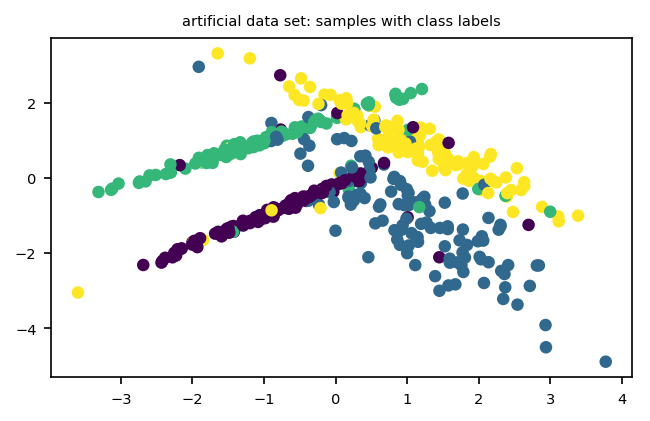

In [3]:
# create data set
X, y_true =  make_classification(n_samples=500, n_features=2, 
                                 n_informative=2, n_redundant=0, n_repeated=0, 
                                 n_classes=4, n_clusters_per_class=1, 
                                 flip_y=0.1, random_state=42)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=25)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

# create annotators
sample_diff_annot_default = DifficultyBasedAnnot(X=X, y_true=y_true)

There are different options to analyse the simulated annotators. The labelling accuracy of each annotator summarises the overall performanc of the annotators on a simulated data set. Another interesting option is to plot the true labelling probababilities for providing the correct class labels.

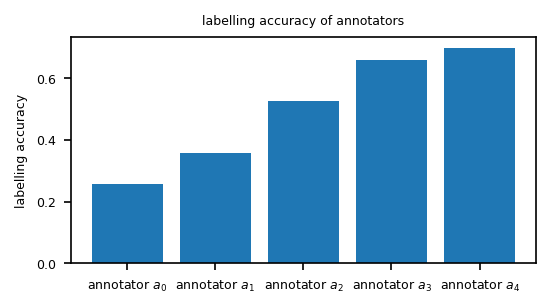

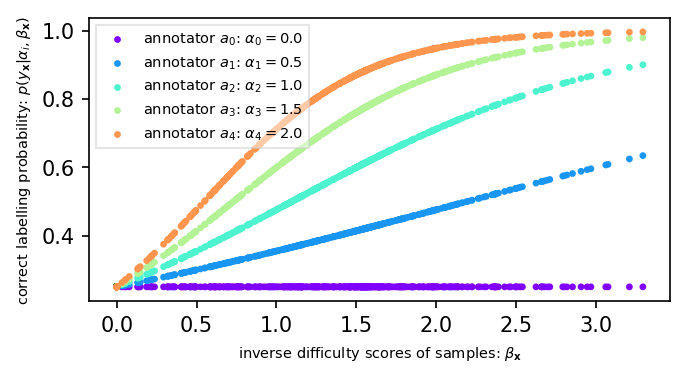

In [4]:
# labelling accuracies
sample_diff_annot_default.plot_labelling_accuracy(X=X, y_true=y_true,
                                                  figsize=(4, 2), fontsize=6)

# plot correct labelling probabilities
sample_diff_annot_default.plot_annotators_labelling_probabilities(figsize=(5, 2.5))
plt.show()

By default, there are `n_annotators=5` simulated annotators $\{a_0, a_1, a_2, a_3, a_4\}$ and their labelling performances $\alpha_i$ are evenly spaced over the interval $[0, 2]$. The sample difficulty levels are estimated by a `sklearn.svm.SVC` (support vector machine for regression) and with a ten times repeated five-fold cross-validation.
This default setting may be changed. For example by altering the parameter `classifiers`. Also, the number of repetitions of the cross-validation can be changed by setting the parameter `n_repeats`, whereas the number of folds is controlled by `n_splits`. A central parameter is named `alphas`, which is an array of the labelling performances of the annotators. In the follwing, we create three annotators and the difficulty scores are estimated by a `sklearn.gaussian_process.GaussianProcessClassifier` and a `sklearn.svm.SVC`.

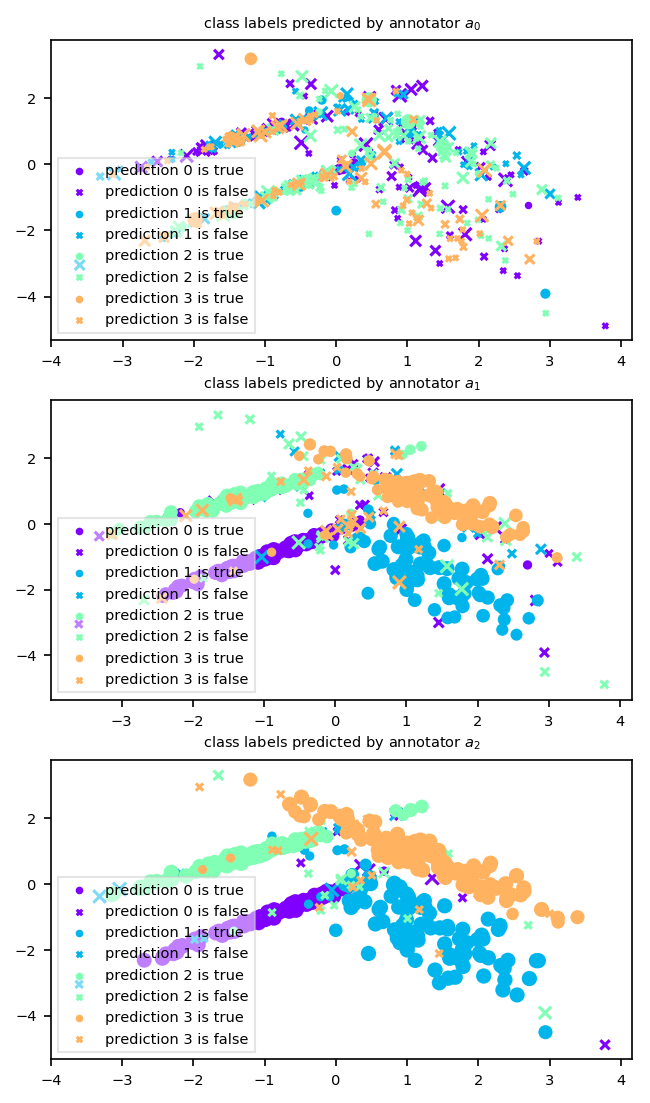

In [5]:
# classifiers to estimate sample difficulty levels
classifiers = [GaussianProcessClassifier(random_state=42), 
               SVC(random_state=42, probability=True)]

# annotator labelling performances
alphas=[-5, 3, 10]

# number of repeated cross validations
n_repeats=5

# number of folds
n_splits = 5

# confidence noise which is added on the true confidence values
# the value confidence_noise[0] = 1 of an entry defines an interval [-1, 1] 
# from which the noise is uniformly drawn for each sample labelled by 
# annotator a_0
confidence_noise=[1, 0, 0]

# create annotator instance
sample_diff_annot = DifficultyBasedAnnot(X=X, y_true=y_true, n_annotators=3, 
                                         alphas=alphas,
                                         classifiers=classifiers, 
                                         n_repeats=n_repeats, n_splits=n_splits, 
                                         confidence_noise=confidence_noise, 
                                         random_state=42)

# plot samples
sample_diff_annot.plot_class_labels(X=X, y_true=y_true, plot_confidence=True)
plt.show()

The three simulated annotators $a_0$, $a_1$, and $a_2$ are visualised in terms of their provided class labels and confidence scores for the given samples. We observe annotator $a_0$ is an adversarial annotator, since this annotator makes many prediction failures and is even worse than randomly guessing class labels. Moreover, this annotator provides high confidence scores for wrong predictions (confidence estimates are not reliable). In contrast, the annotators $a_1$ and $a_2$ provide more accurate class labels. Especially, annotator $a_2$ is the most useful knowledge source in this scenario, because this annotator provides for about $80\%$ of the samples the correct class labels. Moreover, the confidence scores of annotator $a_2$ are meaningful, since low confidences communicate a low probability of a correct class label for the corresponding sample. Hence, this annotator has an reliable self-assessment.

A very important observation of the scatter plots above is the fact that non-adversarial annotators have some samples in common, for which they have problems to provide the correct class labels. This is the result of the sample difficulty estimation. Samples being outliers of a certain class or that are near to decision boundaries (maybe estimated by many different classifier types) are more difficult to label correctly. In contrast, there are also samples that are easy to label, so that almost all non-adversarial annotators label these samples correctly. The difficulty of the samples is plotted in the graph below, where small circles indicate a high difficulty.

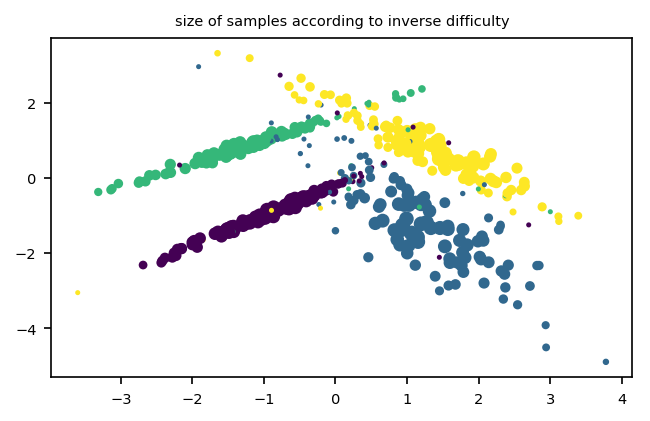

In [6]:
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, 
            s=(sample_diff_annot.betas_+.1)*20)
plt.title('size of samples according to inverse difficulty', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()